# <center><font color='orange' size=35 style = "font-family:Bebas Neue"> Which new artists should you try out? 🎶<font/><center/>
<img src=https://static.billboard.com/files/2020/03/top-100-songs-2000-billboard-1500x845-1584976274-768x433.jpg>
    
# 🎤 Executive Summary

It's the 2000s. Your friends just introduced you to a new artist: Katy Perry and you want to impress them by finding a new artist as well. How will you do so? Will you try to find artists that other users similar to you listen to or artists that are similar to the ones you already listen to?
    
There are multiple media/audio streaming websites and applications nowadays that try to introduce (recommend) artists to their users to keep their playlists updated. These websites collect data on each user's activity, the artists they listen to as well as the listening count, the time (day, month, and year) when a particular artist was heard, and the tags they give these artists, as well as the number of views per artists and their respective tags. This sort of data was used in this project and sourced from [Last FM online music system](http://www.last.fm).

To find these recommendations, the data was MinMax scaled and the different types of collaborative filtering such as the memory based, model based (NMF), and hybrid were then applied. The hybrid was further augmented with a friend only neighborhood. 

The best results were achieved by the friend only hybrid algorithm, the item based collaborative filtering algorithm, and the NMF model based algorithm, in order of rank. This rank was given via a subjective method (judging the songs of output artists) and tag similarity because of the lack of a error metric that could be used uniformly along all algorithms.

These algorithms however, recommended artists that had not been viewed previously by the user, based only on the listening count of different users and artists. This method did not consider that the users belonged to a wide variety of cultures, locations, languages, etc. Despite tags being similar, 2 problems were identified. Firstly, the recommended artists were of different languages, and secondly, the artists that had been viewed only a few times were not part of the contestants for the recommendations. Therefore, this methodology could only be applied in recommending artists with an additional regional or language based filter and not for music recommendation.

# 🎤 Introduction

The data was sourced from [Last FM online music system](http://www.last.fm). All files were stored and retrieved from the following directory.

In [1]:
!ls /mnt/data/public/hetrec2011/lastfm

artists.dat		  tags.dat	    user_taggedartists.dat
hetrec2011-lastfm-2k.zip  user_artists.dat  user_taggedartists-timestamps.dat
readme.txt		  user_friends.dat


## 🎧 Data Description

A detailed data description is readilly available in the readme.txt file.

Some points to note are:
- Data is dated 2011.
- There are 1892 users and 17632 artists.
- The "weight" column in the user_artists.data file is the listening count value that will be used (instead of the commonly used ratings").
- No external sources of data were used to determine artist or user language, geographic location, and other important factors for a meaningful recommendation. The listening count was the sole value used in this project.

In [2]:
!cat /mnt/data/public/hetrec2011/lastfm/readme.txt

# 🎤 Methodology

The methodology follows the following pipeline.

![](pipeline.PNG)

##  🎻 Preliminaries

In [3]:
# import standard libraries.

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import itertools
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.rcParams['axes.grid'] = True

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-1eh7ebuo because the default path (/home/nnigam/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### 🎻 Loading Files

In [4]:
# the tags file was read and saved as a dict.
tags = pd.read_csv('/mnt/data/public/hetrec2011/lastfm/tags.dat', sep='\t',
                   encoding='latin', index_col=0).to_dict()['tagValue']

# all artists and their IDs are read and saved to a dict.
artists = pd.read_csv('/mnt/data/public/hetrec2011/lastfm/artists.dat',
                      sep='\t', index_col=0)
artist_dict = artists['name'].to_dict()

# file with users and their tags for artists
tag_year = pd.read_csv('/mnt/data/public/hetrec2011/lastfm/'
                       'user_taggedartists.dat', sep='\t')
# replacing IDs with tags and artist names
tag_year.replace({'tagID': tags}, inplace=True)
tag_year.replace({'artistID':artist_dict}, inplace=True)

# artists with all their tags
artist_tags = tag_year.groupby('artistID')['tagID'].apply(set)

# friends file
friends = pd.read_csv('/mnt/data/public/hetrec2011/lastfm/user_friends.dat',
                      sep='\t').groupby('userID')['friendID']

# users and their listening counts for some artists
# artist IDs replaced with names
user_artists = (pd.read_csv('/mnt/data/public/hetrec2011/lastfm/'
                           'user_artists.dat', sep='\t')
                .replace({'artistID':artist_dict}))
# pivot table for users and their listening counts for all artists.
user_artists_2 = pd.pivot_table(user_artists, 'weight', 'userID', 'artistID',
                                np.nanmean)
# viewing the pivot table
user_artists_2

artistID,!!!,!DISTAIN,!deladap,#####,#2 Orchestra,$lick,$lick feat. Six-Fo,(1962-1966),(Pre) Kingdom,(We Are) Performance,...,티아라,현아,ＬｕＬｕ,ＭＡＮＮＥＱＵＩＮ,ＰＥＲＥＳＴＲＯＩＫＡ,ＲＥＤ,ＶａｎｅｓｓＡ,ｂｏｏｇｉｅｍａｎ,ｂｏｒｎ,ｍａｃｈｉｎｅ
userID,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###  🎻 Exploratory Data Analysis

All raw data files do not contain null values.

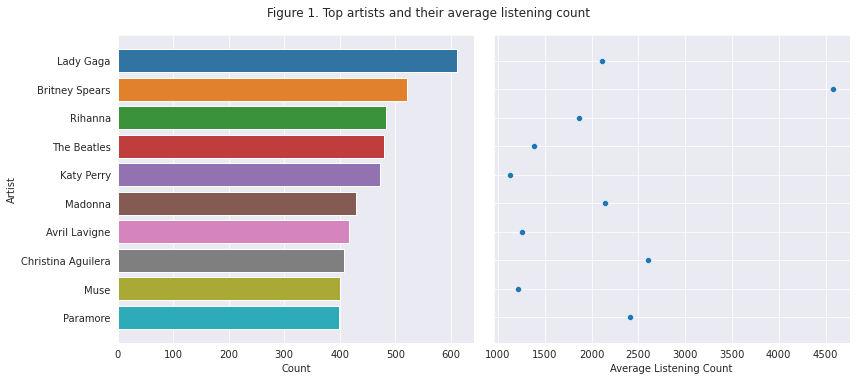

In [5]:
fig, ax = plt.subplots(1,2, figsize=(12, 5), sharey=True)
sns.barplot(x='artistID', y='index',
            data=user_artists.artistID.value_counts()[:10].reset_index(),
            ax=ax[0])
ax[0].set(xlabel="Count", ylabel = "Artist")
sns.scatterplot(x='weight', y='index',
                data=(user_artists.groupby('artistID')['weight'].mean()
                      .loc[user_artists.artistID.value_counts()[:10].index]
                      .reset_index()), ax=ax[1])
ax[1].set(xlabel="Average Listening Count", ylabel = "Artist")
plt.tight_layout()

plt.suptitle('Figure 1. Top artists and their average listening count',
             y=1.05);

The top artists and their average listening count can be seen above.

###  🎻 User Info

The user #179 was chosen for the analysis. The particular user was chosen because of interpretability of its results and the user having enough friends to conduct the Hybrid IB with the friend only neighborhood.

In [6]:
user = 179

In [7]:
# viewing the top 10 artists of the user
list(user_artists_2.loc[user].dropna().sort_values(ascending=False)
     .index[:10])

['Lady Gaga',
 'Britney Spears',
 'Linkin Park',
 'Porcelain and the Tramps',
 'Lindsay Lohan',
 'Christina Aguilera',
 'Placebo',
 'Michael Jackson',
 'The Cure',
 'Porcelain Black']

The particular vibe of this user can be understood by these artists. I would predict the user to be an emo teen girl.

Lady Gaga | Britney Spears | Linkin Park
- | - | -
<img src = 'https://i.pinimg.com/originals/91/d7/93/91d793c5eb3e65477d02ab3640b6485e.jpg' width=250> | <img src = 'https://www.rollingstone.com/wp-content/uploads/2018/06/britney-spears-toxic-3dc5bdf2-c657-46d0-ba5f-e9d6f0b63b20.jpg?w=800' width=400> | <img src = 'https://i0.wp.com/www.altwire.net/wp-content/uploads/2015/10/LPHybridTheory.jpg' width=400>

Porcelain Black | Lindsay Lohan | Christina Aguilera
- | - | -
<img src = https://64.media.tumblr.com/6b1ba4e1f1c54e9ce47013b3de1d0285/tumblr_pgogpjJDsR1sb5rq6o1_400.jpg width=350> | <img src = 'https://img.discogs.com/HkKwQ_qBhEu2A84s-boSTNmczog=/fit-in/600x594/filters:strip_icc():format(jpeg):mode_rgb():quality(90)/discogs-images/R-3651557-1469005517-8207.png.jpg' width=400> | <img src=https://m.media-amazon.com/images/I/6167jXuVcBL.jpg width=500>

To give an idea of the kind of music they produced, the top song of Lady Gaga from that era is attached below.

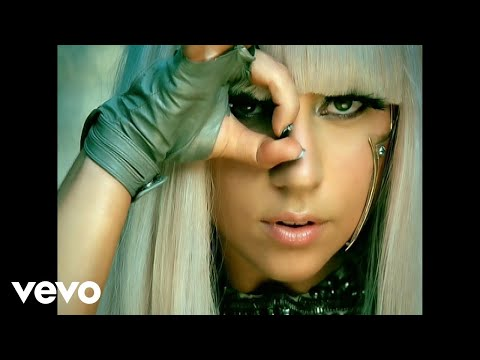

In [8]:
from IPython.display import YouTubeVideo
YouTubeVideo('bESGLojNYSo', width=950, height=300)

The most common tags of these artists are found below. <b> It is assumed that the user would want to explore artists with similar tags. <b>

In [9]:
tags_ = []
for i in list(user_artists_2.loc[user].dropna().sort_values(ascending=False)
              .index[:10]):
    try:
        tags_.append(list(artist_tags.to_dict()[i]))
    except:
        tags_.append([])
    
res1 = sorted(Counter(list(itertools.chain(*tags_))).most_common(15),
              key=lambda x:(-x[1], x[0]))
res1

[('alternative', 9),
 ('awesome', 9),
 ('rock', 9),
 ('favorites', 8),
 ('pop', 8),
 ('sexy', 8),
 ('00s', 7),
 ('amazing', 7),
 ('electronic', 7),
 ('epic', 7),
 ('love', 7),
 ('love at first listen', 7),
 ('sad', 7),
 ('soundtrack', 7),
 ('piano', 6)]

However, the particular tags given by this user for the artists are the following:

In [10]:
tag_year[tag_year.userID==user].tagID.value_counts()

hip hop                                    1
female vocalists                           1
cool                                       1
pop                                        1
diva                                       1
great voice                                1
dance                                      1
ballad                                     1
industrial                                 1
why on earth is this just a bonus track    1
piano                                      1
love                                       1
sexy                                       1
Name: tagID, dtype: int64

###  🎻 Preprocessing

The weight or the listening count is in the range of 1 and 352698 and is not in the form of a fixed rating range and therefore needs to be preprocessed. The MinMax scaling is appropriate for such situations.

In [11]:
user_artists['weight'].describe()

count     92834.00000
mean        745.24393
std        3751.32208
min           1.00000
25%         107.00000
50%         260.00000
75%         614.00000
max      352698.00000
Name: weight, dtype: float64

In [12]:
mins = user_artists_2.min(1)
maxs = user_artists_2.max(1)

df_minmax = pd.DataFrame([((user_artists_2.iloc[i].sub(mins.iloc[i]))
                           /(maxs.iloc[i]-mins.iloc[i]))
                    for i in range(user_artists_2.shape[0])])
df_minmax_2 = df_minmax.to_numpy()

## 🎸 Memory Based Filtering

### 🎸 User-Based Collaborative Filtering

In [13]:
from scipy.spatial.distance import cosine

user_num = np.where(df_minmax[df_minmax.index==user].notna())[1]
user_not = np.where(df_minmax[df_minmax.index==user].isna())[1]

cos = []
for row in range(df_minmax.shape[0]):
    if row!=np.where(df_minmax.index==user)[0]:
        user2_num = np.where(df_minmax.iloc[row].notna())[0]
        user2_not = np.where(df_minmax.iloc[row].isna())[0]
        idx = list(set(user_num).intersection(user2_num))
        cos.append((row, cosine(df_minmax.iloc[:, idx].loc[user],
                                df_minmax.iloc[row, idx])))
    else:
        cos.append((row, np.nan))

sort = pd.DataFrame(cos).dropna()
sort[2] = np.abs(sort[1])
sort = sort.sort_values(by=2)[:30]
similar = sort[0].tolist()
weights = (1 - sort[1]).tolist()
similar_2 = pd.DataFrame(df_minmax.iloc[similar]).dropna(how='all',
                                                           axis=1)

recos_user = [i[0] for i in
            sorted((similar_2.mul(weights, 0).mean(0).reset_index().to_numpy()
                .tolist()), key=lambda x: (-x[1], x[0]))[:10]]

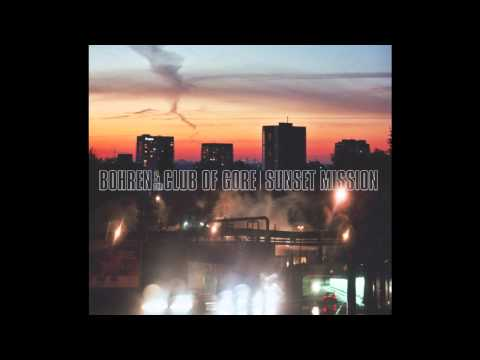

In [14]:
YouTubeVideo('gJXlZ6SjRI8', width=950, height=300)

In [15]:
tags_ = []
for i in recos_user:
    try:
        tags_.append(list(artist_tags.to_dict()[i]))
    except:
        tags_.append([])
    
res2 = sorted(Counter(list(itertools.chain(*tags_))).most_common(15),
              key=lambda x:(-x[1], x[0]))
res2

[('alternative', 3),
 ('indie', 3),
 ('instrumental', 3),
 ('seen live', 3),
 ('90s', 2),
 ('acoustic', 2),
 ('ambient', 2),
 ('chillout', 2),
 ('folk', 2),
 ('indie folk', 2),
 ('indie pop', 2),
 ('lo-fi', 2),
 ('mellow', 2),
 ('new wave', 2),
 ('singer-songwriter', 2)]

There are a few common tags and the rest are similar. However, listening to the audio, it appears to be far from desired.

### 🎸 Item-Based Collaborative Filtering

In [16]:
df_melt = (df_minmax.reset_index()
                .melt('index', var_name='artistID', value_name='weight')
                .dropna())

In [17]:
from surprise import (Reader, Dataset, KNNWithMeans)

knn = KNNWithMeans(k=30, sim_options={'name': 'pearson', 'item_based': True})

reader = Reader(rating_scale=(0, 1)) # 1, 352698
dataset = Dataset.load_from_df(df_melt, reader)

knn.fit(dataset.build_full_trainset())

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [18]:
predictions = []
for col in user_artists_2.loc[user][user_artists_2.loc[user].isna()].index:
    predictions.append(knn.predict(user, col))
predictions = [i[1] for i in sorted(predictions, key=lambda x:-x[3])[:10]]
predictions

['Adriana',
 'Ajda Pekkan',
 'Amycanbe',
 'Dokken',
 'F.L.A.B',
 'Farewell',
 'Gary Revel',
 'Gnawa Diffusion',
 'Hande Yener',
 'Heartscore']

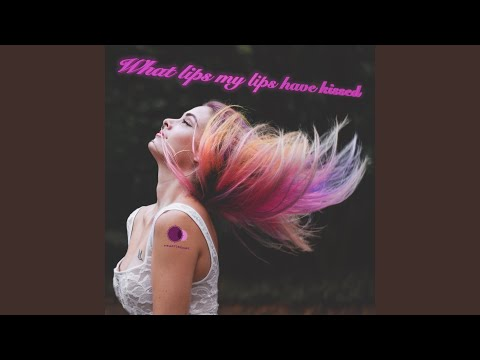

In [19]:
YouTubeVideo('da6bSxlhxP0', width=950, height=300)

In [20]:
tags_ = []
for i in predictions:
    try:
        tags_.append(list(artist_tags.to_dict()[i]))
    except:
        tags_.append([])
    
res3 = sorted(Counter(list(itertools.chain(*tags_))).most_common(15),
              key=lambda x:(-x[1], x[0]))
res3

[('pop', 4),
 ('acoustic', 3),
 ('female vocalists', 3),
 ('rock', 3),
 ('alternative', 2),
 ('alternative rock', 2),
 ('electronic', 2),
 ('1993', 1),
 ('ajda forever', 1),
 ('brazilian', 1),
 ('catholic', 1),
 ('diva', 1),
 ('religious', 1),
 ('seen live', 1),
 ('turkish pop', 1)]

The number of common tags seem to have improved but in doing so, 9 out of the top 10 artists are of different languages. This brings the need to merge similar users in hopes of fitting the language and regional filters.

## 🎷 Model Based Filtering

Various methods from the surprise module were tried. The best results here were achieved by the Non-negative matrix factorization (NMF) method.

###  🎷 NMF Factorization

In [21]:
from surprise import (SVD, SlopeOne, CoClustering, SVDpp, NMF)

reader = Reader(rating_scale=(1, 352698))
dataset = Dataset.load_from_df(user_artists, reader)
algo = NMF(random_state=1)
# algo = CoClustering(200, 150, 20, 1)
# algo = SlopOne()
algo.fit(dataset.build_full_trainset())

In [22]:
predictions = []
for col in user_artists_2.loc[user][user_artists_2.loc[user].isna()].index:
    predictions.append(algo.predict(user, col))
predictions = [i[1] for i in sorted(predictions, key=lambda x:-x[3])[:10]]
predictions

['Blood Ruby',
 'Mushroomhead',
 'HIM',
 'Viking Quest',
 'Reba McEntire',
 'e-gens',
 'The Films',
 'Blur',
 'Rick GhraphiXxX',
 'Simple Minds']

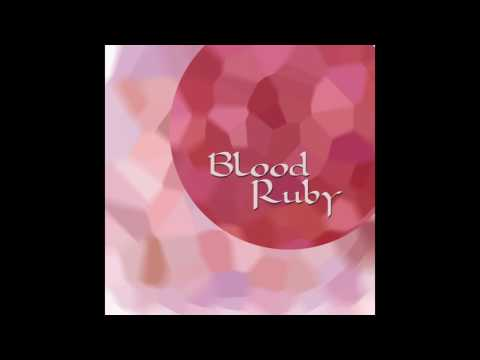

In [23]:
YouTubeVideo('ca42iMix5DE', width=950, height=300)

In [24]:
tags_ = []
for i in predictions:
    try:
        tags_.append(list(artist_tags.to_dict()[i]))
    except:
        tags_.append([])
    
res4 = sorted(Counter(list(itertools.chain(*tags_))).most_common(15),
              key=lambda x:(-x[1], x[0]))
res4

[('alternative', 7),
 ('pop', 5),
 ('rock', 5),
 ('90s', 4),
 ('alternative rock', 4),
 ('indie', 4),
 ('new wave', 4),
 ('britpop', 3),
 ('chillout', 3),
 ('covers', 3),
 ('darkwave', 3),
 ('gothic', 3),
 ('gothic rock', 3),
 ('indie rock', 3),
 ('singer-songwriter', 3)]

Although the top tags are hit and the rest are similar, the tag of "sad" (From user) is different from "goth" or "darkwave"  which are quite dark and gloomy songs (from recommender system).

## 🎺 Combining the Memory Based Filtering Algorithms

From the memory based methods, it was hypothesized that a combination of the two would give better results.

Vozalis and Margaritis (2004) studied 2 methods: 
1. Hybrid-Ib, identifies a reasonably large neighbourhood of similar users and then uses this subset to derive the item-based recommendation model.
2. Hybrid-CF, starts by locating items similar to the one for which we want a prediction, and then, based on that neighbourhood, it generates its user-based predictions.

Only the Hybrid-Ib was used in this project.

### 🎺 Hybrid Item Based Filtering

The method builds on the previous user based algorithm. Instead of the 30 user neighbors previously used, 100 are used instead. The dataframe output of the 100 users is then inputted into an item based filtering algorithm.

In [25]:
sort = pd.DataFrame(cos).dropna()
sort[2] = np.abs(sort[1])
sort = sort.sort_values(by=2)[:100]
similar = sort[0].tolist()
similar.append(np.where(df_minmax.index==user)[0][0])
weights = (1 - sort[1]).tolist()
weights.append(1)
similar_2 = pd.DataFrame(df_minmax.iloc[similar])
similar_2

artistID,!!!,!DISTAIN,!deladap,#####,#2 Orchestra,$lick,$lick feat. Six-Fo,(1962-1966),(Pre) Kingdom,(We Are) Performance,...,티아라,현아,ＬｕＬｕ,ＭＡＮＮＥＱＵＩＮ,ＰＥＲＥＳＴＲＯＩＫＡ,ＲＥＤ,ＶａｎｅｓｓＡ,ｂｏｏｇｉｅｍａｎ,ｂｏｒｎ,ｍａｃｈｉｎｅ
1030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df_melt = (similar_2.reset_index()
                    .melt('index', var_name='artistID', value_name='weight')
                    .dropna())

knn = KNNWithMeans(k=30, sim_options={'name': 'pearson', 'item_based': True})
reader = Reader(rating_scale=(0, 1)) # 1, 352698
dataset = Dataset.load_from_df(df_melt, reader)
knn.fit(dataset.build_full_trainset())

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [27]:
predictions = []
for col in user_artists_2.loc[user][user_artists_2.loc[user].isna()].index:
    predictions.append(knn.predict(user, col))
predictions = [i[1] for i in sorted(predictions, key=lambda x:-x[3])[:10]]    
predictions

['!!!',
 '!DISTAIN',
 '!deladap',
 '#####',
 '#2 Orchestra',
 '$lick',
 '$lick feat. Six-Fo',
 '(1962-1966)',
 '(Pre) Kingdom',
 '(We Are) Performance']

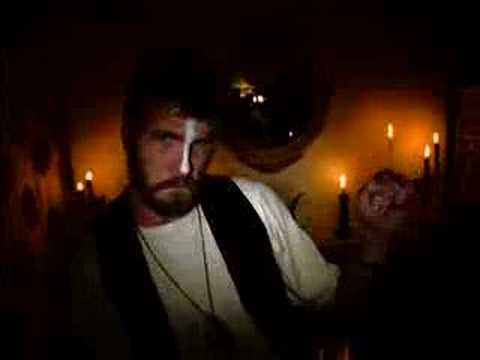

In [28]:
YouTubeVideo('wl0XLHy7kes', width=950, height=300)    

In [29]:
tags_ = []
for i in predictions:
    try:
        tags_.append(list(artist_tags.to_dict()[i]))
    except:
        tags_.append([])
    
res5 = sorted(Counter(list(itertools.chain(*tags_))).most_common(15),
              key=lambda x:(-x[1], x[0]))
res5

[('alternative', 2),
 ('seen live', 2),
 ('american artists', 1),
 ('dance-punk', 1),
 ('dj gold', 1),
 ('electro', 1),
 ('electronic', 1),
 ('indie', 1),
 ('indie rock', 1),
 ('neon space', 1),
 ('party', 1),
 ('post-punk', 1),
 ('potty mouth', 1),
 ('punk funk', 1),
 ('triple j', 1)]

Despite the combining of the 2 methods, the kind of music is similar but not yet quite that level. This may have not worked due to the neighborhood of closest neighbors not being that good predictors. Instead, this model may be augmented by setting this neighborhood to be the users friends.

### 🎺 Friendly Neighborhood

There are only 240 people with a decent number of friends to conduct this analysis on all users. The average number of friends per user is 13.

In [30]:
friends.nunique().sort_values(ascending=False).mean()

13.44291754756871

In [31]:
friends.nunique().sort_values(ascending=False)[friends.nunique()>30]

userID
1543    119
1281    110
831     106
179      97
1503     95
       ... 
753      31
1080     31
1053     31
1380     31
1058     31
Name: friendID, Length: 240, dtype: int64

In [32]:
user_friends = friends.apply(list)
user_friends.loc[user].append(user)
user_friends = df_minmax.loc[user_friends.loc[user]].dropna(how='all', axis=1)
user_friends

artistID,(hed) Planet Earth,*NSYNC,12 Stones,2 Unlimited,2009 Names in Vain,2NE1,2Pac,30 Seconds to Mars,3OH!3,4minute,...,蔡依林,나르샤,남녀공학,동방신기,레인보우,소녀시대,시크릿,원더걸스,티아라,현아
43,NaN,NaN,NaN,NaN,NaN,NaN,0.000159,0.017065,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,NaN,NaN,NaN,NaN,0.084507,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.035089,...,NaN,NaN,NaN,NaN,NaN,0.181957,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.170330,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2054,NaN,NaN,NaN,NaN,NaN,0.001491,NaN,NaN,NaN,0.029009,...,NaN,NaN,NaN,NaN,NaN,0.009267,NaN,NaN,NaN,0.003267
2059,NaN,0.003497,NaN,NaN,NaN,NaN,NaN,NaN,0.004804,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df_melt = (user_friends.reset_index()
                .melt('index', var_name='artistID', value_name='weight')
                .dropna())

knn = KNNWithMeans(k=30, sim_options={'name': 'pearson', 'item_based': True})
reader = Reader(rating_scale=(0, 1))
dataset = Dataset.load_from_df(df_melt, reader)
knn.fit(dataset.build_full_trainset())

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [34]:
predictions = []
for col in user_artists_2.loc[user][user_artists_2.loc[user].isna()].index:
    predictions.append(knn.predict(user, col))
predictions = [i[1] for i in sorted(predictions, key=lambda x:-x[3])[:10]]
predictions

['Röyksopp',
 'The Fall',
 'Matt & Kim',
 'Jeanette',
 'Pataclaun',
 'Duran Duran',
 'Slayer',
 'Riko',
 'Johnny Cash',
 'Nine Inch Nails']

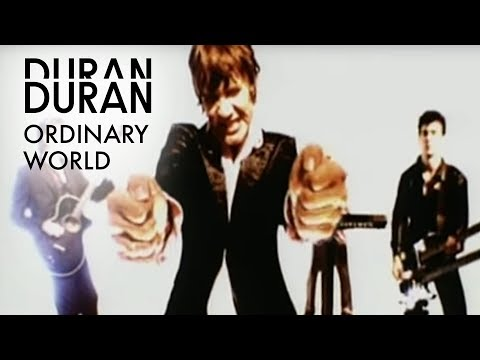

In [35]:
YouTubeVideo('FqIACCH20JU', width=950, height=300) # WgBeu3FVi60, 

In [36]:
tags_ = []
for i in predictions:
    try:
        tags_.append(list(artist_tags.to_dict()[i]))
    except:
        tags_.append([])
    
res6 = sorted(Counter(list(itertools.chain(*tags_))).most_common(15),
              key=lambda x:(-x[1], x[0]))
res6

[('indie', 5),
 ('80s', 4),
 ('indie rock', 4),
 ('love at first listen', 4),
 ('new wave', 4),
 ('rock', 4),
 ('seen live', 4),
 ('00s', 3),
 ('ambient', 3),
 ('electronic', 3),
 ('epic', 3),
 ('experimental', 3),
 ('favorite songs', 3),
 ('mellow', 3),
 ('sexy', 3)]

The algorithm gives the most common number of tags and the song is of a similar type as well.

# 🎤 Results

The summary of results below shows that the Hybrid w/ friends-only neighborhood algorithm gave the highest number of common tags (6) followed by Item-Based (5) and NMF (3). Furthermore, the songs of the artists from these algorithm outputs were judged subjectively and a similar rank was achieved.

It is important to note, however, that these algorithms are trying to recommend artists that have not been heard by the user at all. This means that an artist heard by the user just a few times will be disqualified as a candidate in the recommender system. This methodology may be useful in suggesting artists but not music.

Furthermore, despite the artist tags being similar, artists of different languages were also suggested. This would be troublesome for users not understanding those languages.

In [37]:
df = (pd.DataFrame([[i[0] for i in res1], [i[0] for i in res2], 
              [i[0] for i in res3], [i[0] for i in res4],
              [i[0] for i in res5], [i[0] for i in res6]]).T
      .apply(lambda x: x.sort_values().values))
df.columns = ['Original', 'User Based', 'Item Based', 'NMF', 'Hybrid',
              'Hybrid++']
df.style.applymap(lambda x: "background-color: pink" if x in
                  [i[0] for i in res1] else "background-color: white")

,Original,User Based,Item Based,NMF,Hybrid,Hybrid++
0,00s,90s,1993,90s,alternative,00s
1,alternative,acoustic,acoustic,alternative,american artists,80s
2,amazing,alternative,ajda forever,alternative rock,dance-punk,ambient
3,awesome,ambient,alternative,britpop,dj gold,electronic
4,electronic,chillout,alternative rock,chillout,electro,epic
5,epic,folk,brazilian,covers,electronic,experimental
6,favorites,indie,catholic,darkwave,indie,favorite songs
7,love,indie folk,diva,gothic,indie rock,indie
8,love at first listen,indie pop,electronic,gothic rock,neon space,indie rock
9,piano,instrumental,female vocalists,indie,party,love at first listen


# 🎤 Recommendations

To make a recommender system that could be realistically applied, the following are recommended to augment the findings of this study:
1. Try the Hybrid-CF method. Although a satisfactory output was achieved from the Hybrid-IB with friend-only neighborhood, the paper from which these methods were obtained suggested the Hybrid-CF to be superior.
2. Use additional user and artist demographics and language filters.
3. Recommend music and not artists. Users listening to a readymade playlist would not need to know each artist that comes up but would instead be listening to the music. If the recommended music is similar to the users taste, the user would continue listening. This requires audio features of the music itself, similar to what Spotify does i.e. danceability, acousticness, instrumentalness, etc.
4. Recommending music may also be improved by considering low listening count artists as candidates as well. For this particular user with the top listening count to Lady Gaga, Last FM recommends Katy Perry, which is at the bottom of her list of artists listened to. If the following song of Katy Perry were to be compared to the first song of Lady Gaga in this notebook, the similarity in type of music would be clear.

In [38]:
list(user_artists_2.loc[user].dropna().sort_values(ascending=False).index)

['Lady Gaga',
 'Britney Spears',
 'Linkin Park',
 'Porcelain and the Tramps',
 'Lindsay Lohan',
 'Christina Aguilera',
 'Placebo',
 'Michael Jackson',
 'The Cure',
 'Porcelain Black',
 'Skillet',
 'Eminem',
 'Adam Lambert',
 'Kerli',
 'Marilyn Monroe',
 'Marilyn Manson',
 'Ashlee Simpson',
 'Good Charlotte',
 'Ke$ha',
 'Tila Tequila',
 'Avril Lavigne',
 'Madonna',
 'Kelly Clarkson',
 'The Pretty Reckless',
 'Jeffree Star',
 'Nirvana',
 'The Kills',
 'The Beatles',
 'The Dead Weather',
 'The Subways',
 'The Offspring',
 'Depeche Mode',
 'Dead by Sunrise',
 'Blood Red Shoes',
 'Rihanna',
 'Tokio Hotel',
 '3OH!3',
 'Miley Cyrus',
 'Flyleaf',
 'Simple Plan',
 'Green Day',
 'Silbermond',
 'Evanescence',
 'Katy Perry',
 'The Dresden Dolls',
 'Paramore',
 'Hilary Duff',
 '倖田來未',
 'The Veronicas',
 '30 Seconds to Mars']

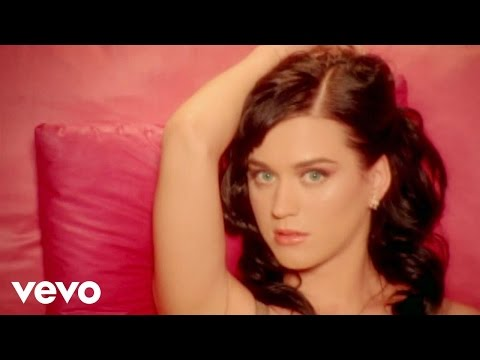

In [39]:
YouTubeVideo('tAp9BKosZXs', width=950, height=300)

# 🎤Conclusion

The need to recommend new artists and music to users of music streaming services can be solved with the use of recommender systems. Although the models used in this project only use user's listening count of artists, satisfactory results were achieved with the Hybrid w/ friend-only neighborhood algorithm. Further filters such as language and geographic location need to be applied to make the model realistically usable. Furthermore, these music streaming services should put more effort in recommending music rather than just artists to prolong usage of their services.

# References:

1. Manolis Vozalis & Konstantinos G. Margaritis. (2004) On the combination of user-based and item-based collaborative filtering, International Journal of Computer Mathematics, 81:9, 1077-1096, DOI: 10.1080/03057920412331272199